# 0. Importing modules

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from IPython.display import clear_output as co
from sklearn.preprocessing import LabelEncoder as le

import tools # Authoral pythom module for the project containing data cleaning and preprocessing functions and methods

---
# 1. Data cleaning and processing

### 1.1 Loading data

In [2]:
df = pd.read_csv('data/historical-database.csv', sep=';')     # Loading provided historical database spreadsheet as a pandas dataframe
df.head(3)

,year,city_code,product_type,product,"destinated_area,"
0,01/01/1974,960b4f2c94a2fb2c,temporary,Others,"0,"
1,01/01/1974,746cc42bfb8f6b62,temporary,Others,"0,"
2,01/01/1974,6cce2bf873870afc,temporary,Others,"0,"


### 1.2 Data formatting

In [3]:
target = 'area'                                                   # defining target variable name
data = df.copy()                                                  # copying the dataframe
data.rename(columns={'destinated_area,': target}, inplace=True)   # Renaming target variable column
data[target].replace(',', np.nan, inplace=True)                   # filling missing values with 'NAN' notation
data[target] = data[target].str.replace(',', '.').astype(float)   # target variable data type conversion to float

if 'clean' not in os.listdir('data'): os.mkdir('data/clean/')                                           # Saving as csv file. Uncomment to save in current directory
#data.to_csv('data/clean/data.csv', index=False) 

### 1.3 Extracting yearly time series of city-product-product_type combinations

In [4]:
raw_series = tools.preprocess.extract_series(                             # Storing individual time series in a python diactionary.
    data, key0='city_code', key1='product', split_category='Others',      # Using city_code-product-product_type notation to identify each time serie.
    split_key='product_type', split_values=['temporary', 'permanent'],    # Change 'save' argument to 'True' to save the dataframes
    sort_by='year', save=False, path='data/series raw/'                       # in a folder in the current directory.
)

### 1.4 Dealing with missing values:

1. Excluding series.
    * Excluding time series with missing values for the testing years (2016, 2017).
    * Excluding time series missing all values for the training years (1974 - 2015).
2. Excluding empty or null first years' values.
    * Droping first time series' values until first non-empty or non-null value.
3. Excluding/filling missing values.
    * Excluding missing values

In [5]:
series, excluded_test_index = tools.preprocess.clean_series(     # returns dict of cleaned time series dataframes
    raw_series, train_min=1, drop_start_zeros=True,              # and list of excluded non empty test values.
    save=False, path='data/clean/series/'
)

Values Count:
n_total            1712
n_values_total    73744
n_values_test      3424
n_values_train    70320
dtype: int64

Excluded count:
series                     605
series_empty               442
series_test_empty          582
series_train_min_<_1       465
values                   40936
values_empty             39035
test_empty                1198
train_empty              37837
non_empty_values          1901
non_empty_test_values       35
n_train_zeros             4796
dtype: int64


#### 1.4.1 Saving excluded non empty test values index as pandas dataframe for later retrieval

In [6]:
# Uncoment to save excluded values index
# pd.Series(excluded_test_index, name='excluded_test_index').to_csv('data/excluded_test_index.csv', index=False)

### 1.5 Concatening and saving remaining series and values into one table for cleaned and raw data

In [7]:
X = tools.preprocess.concat_series(                                   # tools' module function that returns dataframe
    series, le_index=True, save=False, path='data/clean/series.csv'         # with rows as years and columns as time series keys.
)
X_full = tools.preprocess.concat_series(
    raw_series, le_index=False, save=False, path='data/series_raw.csv'
)

In [8]:
X.tail(3).iloc[:, :4]   # last 3 rows and first 4 columns

,960b4f2c94a2fb2c-Others-temporary,960b4f2c94a2fb2c-Others-permanent,960b4f2c94a2fb2c-Rice,960b4f2c94a2fb2c-Beans
41,110.0,535.0,20.0,80.0
42,120.0,540.0,50.0,80.0
43,280.0,700.0,NaN,80.0


---
# 2. Data Exploration
#### 2.0.1 Loading processed time series data

In [9]:
data = pd.read_csv('data/clean/data.csv')                             # provided table (formatted)
X_full = pd.read_csv('data/series_raw.csv', index_col=0)              # time series as columns dataframe (complete)
X = pd.read_csv('data/clean/series.csv', index_col=0)                 # time series as columns dataframe (cleaned)
raw_series = tools.preprocess.load_series(path='data/series raw/')    # time series keys and dataframes as dict keys and values (complete)
series = tools.preprocess.load_series(path='data/clean/series/')      # time series keys and dataframes as dict keys and values (cleaned)
keys = list(series.keys())                                            # time series keys

Done! Loaded 1107 files.


#### 2.0.2 Setting local variables

In [10]:
prods = [                              # List of avaialble product-product_type combinations
    'Rice', 'Beans', 'Cassava',
    'Corn', 'Soy', 'Sorghum',
    'Cocoa', 'Palm oil', 'Açaí',
    'Livestock', 'Others-temporary', 'Others-permanent'
]

## 2.1 Products statistical summary

The statistical summary allows us to observe the unique combination of products and product types as well as the count, mean, deviation and other statistics of the observations in each category.

In [11]:
data.groupby(['product', 'product_type']).describe()  # statistical summary of data grouped by 'product' and 'product_type'

area                                          \
                         count          mean            std        min   
product   product_type                                                   
Açaí      permanent      291.0   1686.230241    5245.467590   3.000000   
Beans     temporary     3414.0    565.310193     990.800160   0.000000   
Cassava   temporary     3848.0   2270.173857    3824.356790   1.000000   
Cocoa     permanent     1801.0   1109.669628    2933.876503   0.000000   
Corn      temporary     3739.0   2110.839262    4579.408423   1.000000   
Livestock pasture       4752.0  98051.332823  141783.939141  33.074823   
Others    permanent     6292.0    582.808964    1468.537558   0.000000   
          temporary     6292.0    133.125238     722.437937   0.000000   
Palm oil  permanent      521.0   2735.932821    4201.624180   0.000000   
Rice      temporary     3418.0   1646.812171    3698.659558   0.000000   
Sorghum   temporary        7.0   4435.000000    3299.412827  10.000000   
Soy       temporary      334.0   7214.934132   15696.564039   5.000000   

                                                                              
                                 25%          50%            75%         max  
product   product_type                                                        
Açaí      permanent        30.000000    130.00000     532.500000    40000.00  
Beans     temporary        70.000000    200.00000     600.000000    12240.00  
Cassava   temporary       380.000000   1000.00000    2500.000000    45000.00  
Cocoa     permanent        30.000000    111.00000     851.000000    38569.00  
Corn      temporary       150.000000    700.00000    2095.000000    98000.00  
Livestock pasture       13008.745125  47204.73691  127344.343025  1626070.83  
Others    permanent         0.000000     95.00000     538.000000    17491.00  
          temporary         0.000000      0.00000      52.000000    12500.00  
Palm oil  permanent       190.000000   1000.00000    3100.000000    21600.00  
Rice      temporary        50.000000    320.00000    1800.000000    60000.00  
Sorghum   temporary      2517.500000   5000.00000    6500.000000     8000.00  
Soy       temporary       270.000000    910.00000    7000.000000   122035.00

In [11]:
data.groupby(['product_type']).describe()  # statistical summary of data grouped by 'product' and 'product_type'

area                                          \
                         count          mean            std        min   
product   product_type                                                   
Açaí      permanent      291.0   1686.230241    5245.467590   3.000000   
Beans     temporary     3414.0    565.310193     990.800160   0.000000   
Cassava   temporary     3848.0   2270.173857    3824.356790   1.000000   
Cocoa     permanent     1801.0   1109.669628    2933.876503   0.000000   
Corn      temporary     3739.0   2110.839262    4579.408423   1.000000   
Livestock pasture       4752.0  98051.332823  141783.939141  33.074823   
Others    permanent     6292.0    582.808964    1468.537558   0.000000   
          temporary     6292.0    133.125238     722.437937   0.000000   
Palm oil  permanent      521.0   2735.932821    4201.624180   0.000000   
Rice      temporary     3418.0   1646.812171    3698.659558   0.000000   
Sorghum   temporary        7.0   4435.000000    3299.412827  10.000000   
Soy       temporary      334.0   7214.934132   15696.564039   5.000000   

                                                                              
                                 25%          50%            75%         max  
product   product_type                                                        
Açaí      permanent        30.000000    130.00000     532.500000    40000.00  
Beans     temporary        70.000000    200.00000     600.000000    12240.00  
Cassava   temporary       380.000000   1000.00000    2500.000000    45000.00  
Cocoa     permanent        30.000000    111.00000     851.000000    38569.00  
Corn      temporary       150.000000    700.00000    2095.000000    98000.00  
Livestock pasture       13008.745125  47204.73691  127344.343025  1626070.83  
Others    permanent         0.000000     95.00000     538.000000    17491.00  
          temporary         0.000000      0.00000      52.000000    12500.00  
Palm oil  permanent       190.000000   1000.00000    3100.000000    21600.00  
Rice      temporary        50.000000    320.00000    1800.000000    60000.00  
Sorghum   temporary      2517.500000   5000.00000    6500.000000     8000.00  
Soy       temporary       270.000000    910.00000    7000.000000   122035.00

## 2.2 Missing values per year (before & after dropping null values)

In [12]:
def missing_per_row(X):  # Calculates dataframe NA and null values per row
    missing_per_year = []
    for index in X.index:
        row = X.loc[index]
        na_values = row.isna().sum()
        zeros = (row==0).sum()
        missing = na_values + zeros
        missing_per_year.append([missing, X.shape[1]-missing, missing/X.shape[1], na_values/X.shape[1], zeros/X.shape[1]])
    return pd.DataFrame(missing_per_year, columns=['missing', 'not_missing', 'missing (%)', 'na_values(%)', 'zeros(%)'])

def plot_missing(df, save_path):  # Plot missing and null values line charts before and after cleaning (percentage and acumulated values)
    missing = missing_per_row(df)
    cols = [2,3,4]
    fig = plt.figure(figsize=(10,3), tight_layout=True)
    ax0, ax1 = [fig.add_subplot(1,2,i) for i in [1,2]]
    missing.iloc[:, cols].plot(marker='o', ms=4, title='Missing values per year', ax=ax0)
    ax0.set(ylabel='Missing values', xlabel='Year (1974 - 2017)')
    missing.cumsum().iloc[:, :2].plot(marker='o', ms=4, title='Cumulative sum of missing values per year', ax=ax1)
    ax1.set(ylabel='Missing values', xlabel='Year (1974 - 2017)')
    if save_path is not None:
        folder, file = os.path.split(save_path)
        try: os.mkdir(folder)
        except: None
        plt.savefig(save_path)
    plt.show()

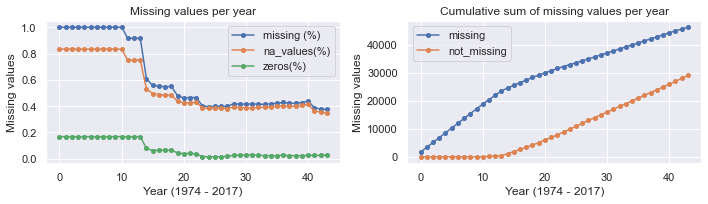

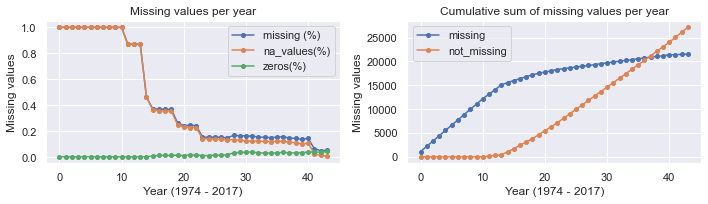

In [13]:
plot_missing(X_full, save_path='plots/missing_values_raw.jpg')
plot_missing(X, save_path='plots/missing_values_clean.jpg')

The blue lines labeled as 'missing' represent the sum of the NA and the null values (orange and green lines). The charts in the top represent missing values before dropping null values and the bottom charts after (both represent the data before dropping na values). The charts in the left show the proportion of na, null and total missing values per row, while charts in the right show the acumulated sum of missing values per row up to "n" rows.

This representation was very important for determination of the missing values strategy. It showed that 100% of the data for the first 10 years is either null or missing and 90% for the first 14 years. Instead of dropping all values for years before the 14th year, another strategy was adopted. In order to preserve non empty values, every time serie was cutted from the beggining until before their first non empty and non null value. Besides, all remaining empty (na) values were dropped. In this way, series ended with different sizes and multi-stepped (non sequential), but preserved most of the information in return.

## 2.3. Missing  time series per city

In [14]:
n_series_per_city = pd.Series(
    [data[data['city_code']==uni_city].groupby(['city_code', 'product', 'product_type']).sum().shape[0] for uni_city in data['city_code'].unique()],
    index=data['city_code'].unique(),
    name='city count'
).value_counts().to_frame()
n_series_per_city.index.name = 'nº of series'

In [15]:
n_series_per_city

,city count
nº of series,
12,138
11,5
1,1


#### Missing values per city_code:
* 138 cities have values for all 12 types-products
* 5 cities have values for 11 types-products
* 1 city have values for only 1 type-product
* 12 city-product series are missing

### 2.4 Null values by product (before & after cleaning)

In [16]:
def count_cats_nulls(df, prods, col='area'):
    cats_indexes = tools.category_index.get_ctgr_combs_indexes(df, prods)
    type_stats = []
    for key in cats_indexes.keys():
        type_area = df[col][cats_indexes[key]]
        n_null = (type_area==0).sum()
        n = len(type_area.dropna())
        p = n_null / n
        type_stats.append([key, n, n_null, n-n_null, n_null/n])
    return pd.DataFrame(type_stats, columns=['product_type', 'n', 'n_null', 'n_non_null', 'p_null']).set_index('product_type')

def null_report(data, cut=13, cut_col='year'):
    data_cut = data[[int(year[-4:])>(1974+cut) for year in data[cut_col]]]
    report, report_clean = [count_cats_nulls(df, prods, col='area') for df in [data, data_cut]]
    report_clean.columns = [col+'_clean' for col in report_clean.columns]
    print(f'Null values before & after data cleaning (excluding first {cut} years):')
    display(pd.concat([report, report_clean], 1))

#### 2.4.1 Observing the distribution of null values between products before and after cleaning

In [17]:
null_report(data, cut=13)

Null values before & after data cleaning (excluding first 13 years):


,n,n_null,n_non_null,p_null,n_clean,n_null_clean,n_non_null_clean,p_null_clean
product_type,,,,,,,,
Rice,3418,1,3417,0.000293,3418,1,3417,0.000293
Beans,3414,1,3413,0.000293,3414,1,3413,0.000293
Cassava,3848,0,3848,0.000000,3848,0,3848,0.000000
Corn,3739,0,3739,0.000000,3739,0,3739,0.000000
Soy,334,0,334,0.000000,334,0,334,0.000000
Cocoa,1801,6,1795,0.003331,1801,6,1795,0.003331
Palm oil,521,4,517,0.007678,521,4,517,0.007678
Livestock,4752,0,4752,0.000000,4320,0,4320,0.000000
Others-temporary,6292,3214,3078,0.510807,4290,1212,3078,0.282517


## 2.5 Visualizing time series

### 2.5.1 Setting isolated series indexes to pandas datetime index

In [18]:
dt_series = {}
for key in keys:
    dt_series[key] = series[key].set_index(pd.DatetimeIndex(series[key]['year'].astype('datetime64[Y]')))

cities = data['city_code'].unique()
ts_ij = {city: {} for city in cities}
for key in keys:
    cats = key.split('-')
    city, prodtype = cats[0], '-'.join(cats[1:])
    ts_ij[city][prodtype] = dt_series[key]

### 2.5.2 Defining plotting functions

In [19]:
def plot_products_series(ts_ij, prods, save_path):
    cities = list(ts_ij.keys())
    fig = plt.figure(figsize=(12,12.5), tight_layout=True)
    axes = [fig.add_subplot(5, 3, i) for i in range(1, len(prods)+1)]
    for city in cities:
        i = ts_ij[city]
        for product, ax in zip(prods, axes):
            ax.set(title='Time series - product ' + product, ylabel='City destinated area')
            if product in i.keys():
                ij = i[product]
                if len(ij): 
                    ij[target].plot(ax=ax, lw=2)
    # ax.legend(loc='best')
    if save_path is not None:
        folder, file = os.path.split(save_path)
        try: os.mkdir(folder)
        except: None
        plt.savefig(save_path)
    plt.show()

In [20]:
def plot_n_cities(ts_ij, cities, n_cities=4, save_path='plots/Séries Temporais por Cidade.png'):
    n_cols = 2    
    n_rows = (n_cities//n_cols+1 if n_cities%4!=0 else n_cities//n_cols)
    fig = plt.figure(figsize=(10/2*n_cols, 10/4*n_rows), tight_layout=True)
    axes = [fig.add_subplot(n_rows, n_cols, i) for i in range(1, n_cities+1)]
    for city, ax in zip(np.random.choice(cities, n_cities), axes):
        i = ts_ij[city]
        ax.set(title=f'Products time series - city {city}', ylabel='Product destinated area')
        for product in prods:
            if (product in i.keys()) and product!='Livestock' :
                ij = i[product]
                if len(ij): 
                    points = ij[target]; points.name=product
                    points.plot(ax=ax, lw=2, label=product)
    ax.legend(loc=(1.1,0), facecolor=(1,1,1,0.2))
    if save_path is not None:
        folder, file = os.path.split(save_path)
        try: os.mkdir(folder)
        except: None
        plt.savefig(save_path)
    plt.show()

### 2.5.3 Visualizing time series for different products within a single city (6 sample cities)

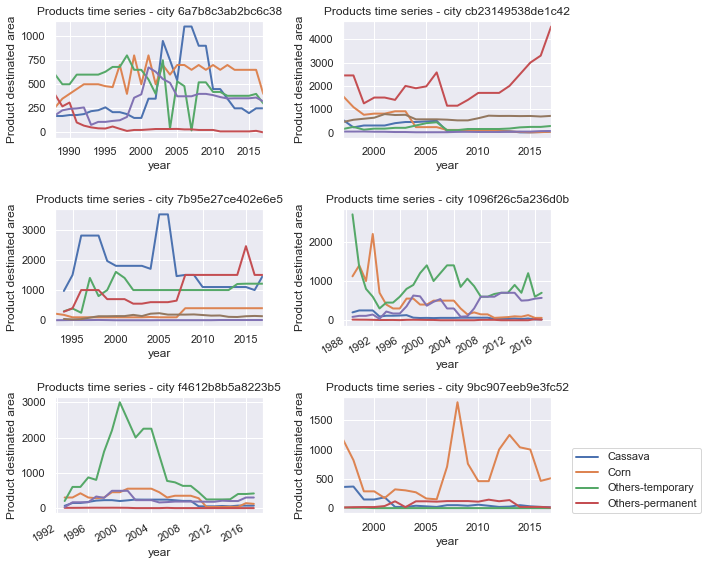

In [21]:
plot_n_cities(ts_ij, cities, n_cities=6)

### 2.5.4 Visualizing time series of a single product for different cities (12 products)

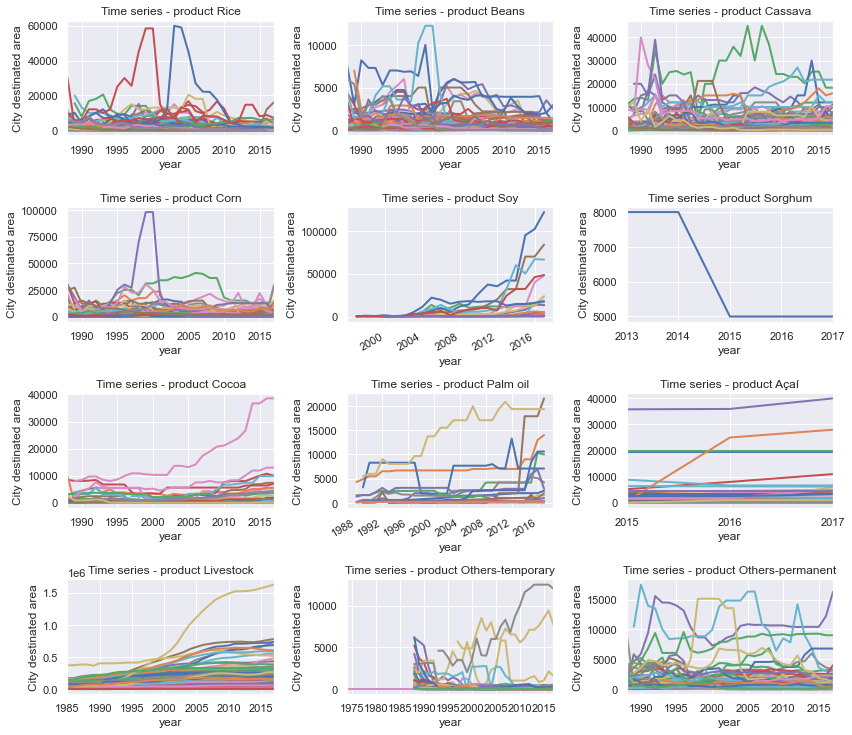

In [22]:
plot_products_series(ts_ij, prods, save_path='plots/Séries Temporais por Produto-Tipo.png')